<a href="https://colab.research.google.com/github/dltnqls9788/AI-YangJaeHub/blob/main/kaggle_Alzheimer's_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?datasetId=457093&sortBy=voteCountm


https://www.kaggle.com/code/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading

MRI image  
4가지 class 
1. 가벼운 치매(Mild Demented)
2. 중증도의 치매(Moderate Demented)
3. 비 치매(Non Demented)
4. 매우 약한 치매(Very Mild Demented)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/AI_hub/

/content/drive/MyDrive/AI_hub


In [ ]:
!ls

 AlzData.zip
'Alzheimer'\''s Dataset(kaggle).ipynb'
 Aniforest_v1.ipynb
 Aniforest_v2_for
 cnn-cifar10.ipynb
 cnn-fashionMnist-v1
 cnn-VGG11.ipynb
 kaggle_pokemon_data_augmentation-ing.ipynb
'텍스트 유사도 기반 챗봇 만들기(pytorch).ipynb'
 test
 train


In [ ]:
!unzip AlzData.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/MildDemented/mildDem207.jpg  
  inflating: train/MildDemented/mildDem208.jpg  
  inflating: train/MildDemented/mildDem209.jpg  
  inflating: train/MildDemented/mildDem21.jpg  
  inflating: train/MildDemented/mildDem210.jpg  
  inflating: train/MildDemented/mildDem211.jpg  
  inflating: train/MildDemented/mildDem212.jpg  
  inflating: train/MildDemented/mildDem213.jpg  
  inflating: train/MildDemented/mildDem214.jpg  
  inflating: train/MildDemented/mildDem215.jpg  
  inflating: train/MildDemented/mildDem216.jpg  
  inflating: train/MildDemented/mildDem217.jpg  
  inflating: train/MildDemented/mildDem218.jpg  
  inflating: train/MildDemented/mildDem219.jpg  
  inflating: train/MildDemented/mildDem22.jpg  
  inflating: train/MildDemented/mildDem220.jpg  
  inflating: train/MildDemented/mildDem221.jpg  
  inflating: train/MildDemented/mildDem222.jpg  
  inflating: train/MildDemented/mildDem223.jpg  
  inflating: train/MildDemented/mil

In [ ]:
!pip install tensorflow==2.3.0 -q

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.version)

Number of replicas: 1
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
IMAGE_SIZE = [176, 208]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
import os
os.listdir('./train')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
train_ds.class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
#train_ds.class_names = class_names
#val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

np.shape(images) (16, 176, 208, 3)


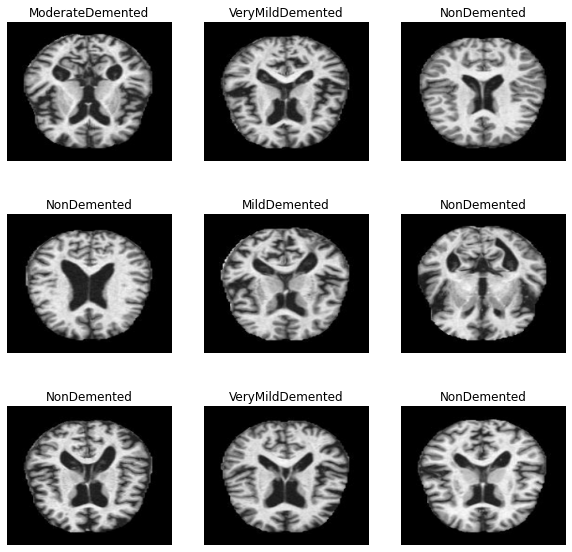

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  print('np.shape(images)',np.shape(images))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Feature Engineering
def one_hot_label(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label 

train_ds = train_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
NUM_IMAGES = []

for label in class_names:
  dir_name = './train/' + label[:-2] + 'ed'
  print(dir_name)
  NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

./train/MildDemented
./train/ModerateDemented
./train/NonDemented
./train/VeryMildDemented


In [ ]:
NUM_IMAGES  # 불균형 데이터(치매가 없는 경우가 가장 많음)

[717, 52, 2560, 1792]

In [ ]:
# Conv block 
def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding="same"),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])

  return block

In [ ]:
# Dense block
def dens_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])

  return block

In [ ]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
      tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding="same"),
      tf.keras.layers.SeparableConv2D(16, 3, activation='relu', padding="same"),
      tf.keras.layers.MaxPool2D(),

      conv_block(32),
      conv_block(64),

      conv_block(128),
      tf.keras.layers.Dropout(0.2),

      conv_block(256),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      dens_block(512, 0.7),
      dens_block(128, 0.5),
      dens_block(64, 0.3),

      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

In [ ]:
with strategy.scope():
  model = build_model()

  METRICS = [tf.keras.metrics.AUC(name='auc')]

  model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(),
      metrics=METRICS
  )

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/10
257/257 [==============================] - 429s 2s/step - loss: 1.1176 - auc: 0.7801 - val_loss: 3.3605 - val_auc: 0.7025
Epoch 2/10
257/257 [==============================] - 403s 2s/step - loss: 0.9760 - auc: 0.8144 - val_loss: 4.3158 - val_auc: 0.6782
Epoch 3/10
257/257 [==============================] - 406s 2s/step - loss: 0.9859 - auc: 0.8094 - val_loss: 2.5317 - val_auc: 0.7350
Epoch 4/10
257/257 [==============================] - 414s 2s/step - loss: 0.9578 - auc: 0.8188 - val_loss: 1.0146 - val_auc: 0.8159
Epoch 5/10
257/257 [==============================] - 413s 2s/step - loss: 0.9364 - auc: 0.8283 - val_loss: 0.9186 - val_auc: 0.8340
Epoch 6/10
257/257 [==============================] - 410s 2s/step - loss: 0.9171 - auc: 0.8378 - val_loss: 8.5954 - val_auc: 0.6473
Epoch 7/10
 23/257 [=>............................] - ETA: 5:28 - loss: 0.8980 - auc: 0.8399

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
_ = model.evaluate(test_ds)